In [1]:
scores = '../out/ko_scores.txt'
dev = '../out/deviating.tsv'
sgd = '../out/SGD_features.tab'

In [2]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
from matplotlib_venn import venn2, venn3

sns.set_style('white')

plt.rc('font', size=12)

In [3]:
import random
import itertools
import numpy as np
import pandas as pd

In [4]:
g = pd.read_table(sgd, sep='\t', header=None)
gn = g[g[1] == 'ORF'].set_index(3)[4].dropna().to_dict()
gd = g[g[1] == 'ORF'].set_index(3)[15].dropna().to_dict()

In [5]:
m = pd.read_table(scores, index_col=[0, 2, 1])
m['phenotype'] = m['qvalue'] < 0.05
genes = None
for s in {x[0] for x in m.index}:
    gs = {x[0] for x in m.loc[s].index}
    if genes is None:
        genes = gs
    else:
        genes = genes.intersection(gs)
    print(s, len(gs))
print('')
print('total', len(genes))
genes = sorted(genes)
m = m.loc[(slice(None), genes),]

S288C 4889
Y55 4190
UWOP 4014
YPS 4093

total 3786


In [6]:
strains = ['S288C', 'Y55',
           'UWOP', 'YPS']
cstrains = {x: c
            for x, c in zip(strains, sns.color_palette('Set1', len(strains)))}

In [7]:
d = pd.read_table(dev, index_col=[4, 5, 1, 0])
d = d.loc[(slice(None), slice(None), genes),]
d = d.sort_index().reset_index()

In [8]:
def do_analysis(d, strains,
                qvalue = 0.01,
                scores_qvalue = 0.05):
    res = []
    ds = {}
    de = {}
    dw = {}
    for s in strains:
        x1 = d[d['strain1'] == s]
        x2 = d[d['strain2'] == s]
        x1 = x1.rename(columns={'strain1': 'strain',
                                'phenotype1': 'phenotype',
                                'scores-qvalue1': 'scores-qvalue',
                                'scores-qvalue2': 'other-qvalue',
                                'strain2': 'other',
                                'phenotype2': 'otherp',
                                'scores1': 'scores',
                                'scores2': 'others'}
                      ).T.sort_index().T
        x2 = x2.rename(columns={'strain2': 'strain',
                                'phenotype2': 'phenotype',
                                'scores-qvalue2': 'scores-qvalue',
                                'scores-qvalue1': 'other-qvalue',
                                'strain1': 'other',
                                'phenotype1': 'otherp',
                                'scores2': 'scores',
                                'scores1': 'others'}
                      ).T.sort_index().T
        x = pd.concat([x1, x2]).reindex()

        y = x[(x['phenotype']) | (x['otherp'])]

        for o in set(strains).difference([s]):
            e = y[
                  (y['scores-qvalue'] <= scores_qvalue) &
#                   (y['phenotype']) &
                  (y['qvalue'] < qvalue) &
                  (y['other'] == o)].set_index(['gene',
                                                'condition'])
            sh = y[
                   (y['scores-qvalue'] <= scores_qvalue) &
                   (y['other-qvalue'] <= scores_qvalue) &
#                    (y['phenotype']) &
#                    (y['otherp']) &
                   (y['qvalue'] >= qvalue) &
                   (y['other'] == o)].set_index(['gene',
                                                 'condition'])
            sw = y[
                   (y['scores-qvalue'] <= scores_qvalue) &
                   (y['other-qvalue'] <= scores_qvalue) &
#                    (y['phenotype']) &
#                    (y['otherp']) &
                   (y['qvalue'] < qvalue) &
                   (np.sign(y['scores']) != np.sign(y['others'])) &
                   (y['other'] == o)].set_index(['gene',
                                                 'condition'])

            
            de[s] = {x[0] for x in e.index}
            dw[s] = sw.index

            p = sh.shape[0] + e.shape[0]

            res.append((s, o,
                        2,
                        sh.shape[0]/p,
                        e.shape[0]/p,
                        sw.shape[0]/p,
                        sh.shape[0],
                        e.shape[0],
                        sw.shape[0]))

        for i in [2, 3]:
            for o in itertools.combinations(set(strains).difference([s]),
                                            i):
                e = y[
                      (y['scores-qvalue'] <= scores_qvalue) &
#                       (y['phenotype']) &
                      (y['qvalue'] < qvalue) &
                      (y['other'].isin(o))].set_index(['gene',
                                                       'condition']).sort_index()
                sh = y[
                       (y['scores-qvalue'] <= scores_qvalue) &
                       (y['other-qvalue'] <= scores_qvalue) &
#                        (y['phenotype']) &
#                        (y['otherp']) &
                       (y['qvalue'] >= qvalue) &
                       (y['other'].isin(o))].groupby(['gene',
                                                      'condition'])['strain'].count()
                sh = sh[sh >= i]
                sw = y[
                       (y['scores-qvalue'] <= scores_qvalue) &
                       (y['other-qvalue'] <= scores_qvalue) &
#                        (y['phenotype']) &
#                        (y['otherp']) &
                       (y['qvalue'] < qvalue) &
                       (np.sign(y['scores']) != np.sign(y['others'])) &
                       (y['other'].isin(o))].groupby(['gene',
                                                      'condition'])['strain'].count()
                sw = sw[sw >= i]

                e = e.loc[e.index.difference(sh.index)]

                p = sh.shape[0] + e.shape[0]

                if i == 3:
                    ds[s] = sh.index

                res.append((s, ','.join(o),
                            i+1,
                            sh.shape[0]/p,
                            e.shape[0]/p,
                            sw.shape[0]/p,
                            sh.shape[0],
                            e.shape[0],
                            sw.shape[0]/p))

    r = pd.DataFrame(res,
                     columns=['strain',
                              'others',
                              'comparisons',
                              'shared',
                              'exclusive',
                              'switched',
                              'nshared',
                              'nexclusive',
                              'nswitched'])

    p = r.set_index(['strain',
                     'others',
                     'comparisons']).stack()

    p = p.to_frame().reset_index()
    p.columns = ['strain',
                 'others',
                 'comparisons',
                 'variable',
                 'value']
    
    return p, ds, de, dw

/home/mgalactus/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


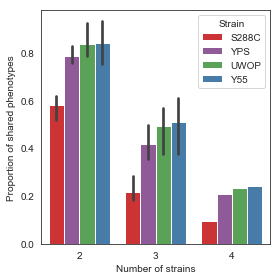

In [9]:
p, ds, de, dw = do_analysis(d, strains)

sns.catplot(x='comparisons', y='value',
            hue='strain',
            height=4, aspect=1,
            kind='bar', data=p[p['variable'] == 'shared'],
            hue_order=p[(p['variable'] == 'shared') &
                        (p['comparisons'] == 2)
                       ].groupby('strain')['value'].mean().sort_values().index,
            palette=[cstrains[x] for x in p[(p['variable'] == 'shared') &
                                            (p['comparisons'] == 2)
                                           ].groupby('strain')['value'
                                           ].mean().sort_values().index],
            legend=False)

plt.legend(title='Strain',
           loc='upper right')

plt.ylabel('Proportion of shared phenotypes')
plt.xlabel('Number of strains')

sns.despine(top=False,
            right=False)

plt.savefig('deviations-sets-increasing.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('deviations-sets-increasing.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [10]:
p[(p['variable'] == 'switched') &
  (p['comparisons'] == 2)].groupby('strain')['value'].mean().sort_values()

strain
S288C    0.028626
Y55      0.035781
UWOP     0.038728
YPS      0.051088
Name: value, dtype: float64

In [11]:
sw = d[(d['scores-qvalue1'] <= 1E-2) &
       (d['scores-qvalue2'] <= 1E-2) &
       (d['qvalue'] < 0.01) &
       (np.sign(d['scores1']) != np.sign(d['scores2']))].copy()
sw['name'] = [gn.get(x, x)
              for x in sw['gene']]
sw['diff'] = abs(sw['scores1'] - sw['scores2'])

sw.sort_values('diff',
               ascending=False)[['strain1', 'strain2',
                                 'condition', 'name',
                                 'scores1', 'scores2']]

,strain1,strain2,condition,name,scores1,scores2
348367,S288C,YPS,aa starvation (48H),MET5,6.530706,-9.607977
72878,S288C,UWOP,aa starvation (48H),MET5,6.530706,-9.053751
97003,S288C,UWOP,Caffeine 15mM (48H),CCS1,3.189577,-10.909377
40187,S288C,UWOP,Maltose 2% (48H),PET122,-8.277797,3.173466
814527,Y55,YPS,NaCl 0.4M (48H),SNU66,3.892053,-4.670797
97004,S288C,UWOP,Caffeine 20mM (48H),CCS1,3.003211,-5.490869
112767,S288C,UWOP,NaCl 0.6M (48H),YNR029C,-4.869349,3.468520
561926,UWOP,YPS,Maltose 2% (48H),MAL32,-4.747533,3.448490
487198,UWOP,Y55,NaCl 0.6M (72H),SDH1,-4.785274,3.121367
58045,S288C,UWOP,Maltose 2% (48H),INM1,3.039084,-4.608169


In [12]:
sw = d[(d['scores-qvalue1'] <= 0.05) &
       (d['scores-qvalue2'] <= 0.05) &
       (d['qvalue'] < 0.01) &
       (np.sign(d['scores1']) != np.sign(d['scores2']))].copy()
sw['name'] = [gn.get(x, x)
              for x in sw['gene']]
sw['diff'] = abs(sw['scores1'] - sw['scores2'])

sw.sort_values('diff',
               ascending=False)[['strain1', 'strain2',
                                 'condition', 'name', 'gene',
                                 'scores1', 'scores2']].to_csv('switches.tsv',
                                                               sep='\t',
                                                               index=False)

In [13]:
p[(p['variable'] == 'switched') &
  (p['comparisons'] == 3)].groupby('strain')['value'].mean().sort_values()

strain
Y55      0.000000
YPS      0.001745
UWOP     0.002215
S288C    0.003336
Name: value, dtype: float64

In [14]:
p[(p['variable'] == 'switched') &
  (p['comparisons'] == 4)].groupby('strain')['value'].mean().sort_values()

strain
S288C    0.0
UWOP     0.0
Y55      0.0
YPS      0.0
Name: value, dtype: float64

In [15]:
p[(p['variable'] == 'exclusive') &
  (p['comparisons'] == 2)].groupby('strain')['value'].mean().sort_values()

strain
Y55      0.159179
UWOP     0.164460
YPS      0.213032
S288C    0.420256
Name: value, dtype: float64

In [16]:
p[(p['variable'] == 'shared') &
  (p['comparisons'] == 2)].groupby('strain')['value'].mean().sort_values()

strain
S288C    0.579744
YPS      0.786968
UWOP     0.835540
Y55      0.840821
Name: value, dtype: float64

In [17]:
p[(p['variable'] == 'exclusive') &
  (p['comparisons'] == 3)].groupby('strain')['value'].mean().sort_values()

strain
Y55      0.492590
UWOP     0.506836
YPS      0.581084
S288C    0.782208
Name: value, dtype: float64

In [18]:
p[(p['variable'] == 'shared') &
  (p['comparisons'] == 3)].groupby('strain')['value'].mean().sort_values()

strain
S288C    0.217792
YPS      0.418916
UWOP     0.493164
Y55      0.507410
Name: value, dtype: float64

In [19]:
p[(p['variable'] == 'exclusive') &
  (p['comparisons'] == 4)].groupby('strain')['value'].mean().sort_values()

strain
Y55      0.756667
UWOP     0.766026
YPS      0.792614
S288C    0.906170
Name: value, dtype: float64

In [20]:
p[(p['variable'] == 'shared') &
  (p['comparisons'] == 4)].groupby('strain')['value'].mean().sort_values()

strain
S288C    0.093830
YPS      0.207386
UWOP     0.233974
Y55      0.243333
Name: value, dtype: float64

In [21]:
pp = None
for i, j in zip([1E-10, 1E-8, 1E-6, 1E-4, 1E-2, 0.05],
                [1E-8, 1E-6, 1E-4, 1E-2, 0.05, 0.1]):
    pt, _, _, _ = do_analysis(d, strains,
                        qvalue=0.01,
                        scores_qvalue=i)
    pt['threshold'] = j
    if pp is None:
        pp = pt
    else:
        pp = pd.concat([pp, pt])

/home/mgalactus/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


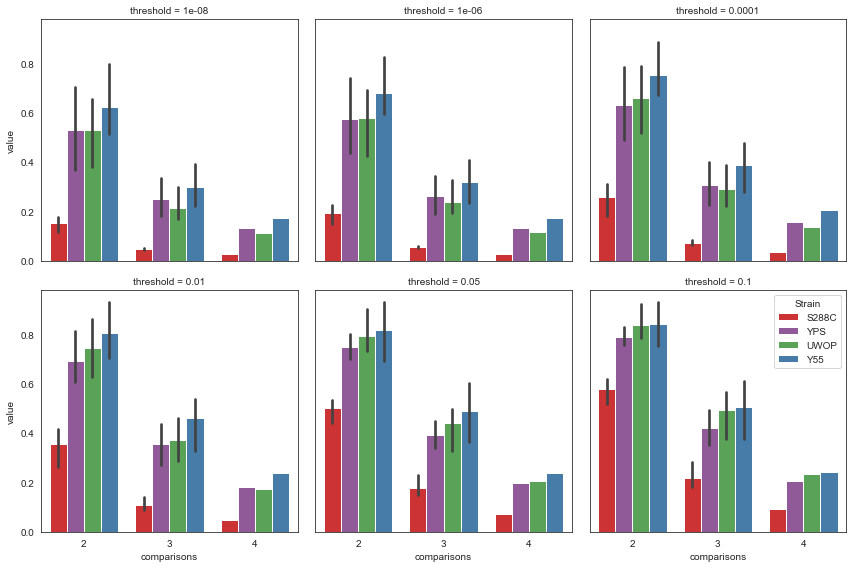

In [22]:
sns.catplot(x='comparisons', y='value',
            hue='strain', col='threshold',
            height=4, aspect=1,
            col_wrap=3,
            kind='bar', data=pp[pp['variable'] == 'shared'],
            hue_order=pp[(pp['variable'] == 'shared') &
                        (pp['comparisons'] == 2)
                       ].groupby('strain')['value'].mean().sort_values().index,
            palette=[cstrains[x] for x in pp[(pp['variable'] == 'shared') &
                                            (pp['comparisons'] == 2)
                                           ].groupby('strain')['value'
                                           ].mean().sort_values().index],
            legend=False)

plt.legend(title='Strain',
           loc='upper right')

# plt.ylabel('Proportion of shared phenotypes')
# plt.xlabel('Number of strains')

sns.despine(top=False,
            right=False)

In [23]:
mm = pd.DataFrame([(gn.get(x, x), x, y)
                 for x, y in
                 sorted(set(ds['S288C']),
                        key=lambda x: x[1])],
                 columns=['name', 'gene', 'condition'])

In [24]:
mm.to_csv('deviations_rarefaction.tsv',
         sep='\t',
         index=False)

In [25]:
mm

,name,gene,condition
0,DCW1,YKL046C,"2,4-Dichlorophenoxyacetic acid (48H)"
1,BRP1,YGL007W,"2,4-Dichlorophenoxyacetic acid (48H)"
2,KRE1,YNL322C,"2,4-Dichlorophenoxyacetic acid (48H)"
3,RAV1,YJR033C,"2,4-Dichlorophenoxyacetic acid (48H)"
4,YNR005C,YNR005C,"2,4-Dichlorophenoxyacetic acid (48H)"
5,ARC18,YLR370C,39ºC (48H)
6,CGR1,YGL029W,39ºC (48H)
7,SWM1,YDR260C,39ºC (48H)
8,HSM3,YBR272C,39ºC (48H)
9,CGR1,YGL029W,39ºC (72H)


In [26]:
(len([(gn.get(x, x), y)
      for x, y in sorted(set(ds['S288C']), key=lambda x: x[1])]), 
 len([(gn.get(x, x), y)
      for x, y in sorted(set(ds['YPS']), key=lambda x: x[1])]),
 len([(gn.get(x, x), y)
      for x, y in sorted(set(ds['Y55']), key=lambda x: x[1])]),
 len([(gn.get(x, x), y)
      for x, y in sorted(set(ds['UWOP']), key=lambda x: x[1])]),)

(73, 73, 73, 73)

In [27]:
f = open('genes.bed', 'w')
for ch, start, stop, gene in g[g[3].isin(mm['gene'].unique())][[6, 9, 10, 3]].values:
    if start > stop:
        tmp = start
        start = stop
        stop = tmp
    f.write('%s\t%d\t%d\t%s\tshared\n' % (ch.replace('chromosome ', 'chr'),
          start, stop, gene))

In [28]:
for strain, genes in de.items():
    for ch, start, stop, gene in g[g[3].isin(genes)][[6, 9, 10, 3]].values:
        if start > stop:
            tmp = start
            start = stop
            stop = tmp
        f.write('%s\t%d\t%d\t%s\tstrain%s\n' % (ch.replace('chromosome ', 'chr'),
              start, stop, gene, strain))

In [29]:
pm = (m.reset_index().groupby('gene')['phenotype'].sum()
      /
      m.reset_index().groupby('gene')['phenotype'].count())

In [30]:
agenes = list(pm[pm > 0].index)

In [31]:
for i in range(100):
    random.shuffle(agenes)
    rgenes = agenes[:len(mm['gene'].unique())]
    for ch, start, stop, gene in g[g[3].isin(rgenes)][[6, 9, 10, 3]].values:
        if start > stop:
            tmp = start
            start = stop
            stop = tmp
        f.write('%s\t%d\t%d\t%s\trandom%d\n' % (ch.replace('chromosome ', 'chr'),
              start, stop, gene, i))
f.close()

In [32]:
!bedtools intersect -a genes.bed -b ../data/variants/SGRP2-cerevisiae-freebayes-snps-Q30-GQ30.vcf.gz > out.bed

In [33]:
o = pd.read_table('out.bed', header=None)
o.columns = ['chromosome',
             'start',
             'stop',
             'gene',
             'set']
o = o.groupby(['set', 'gene'])['chromosome'].count().reset_index()

/home/mgalactus/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


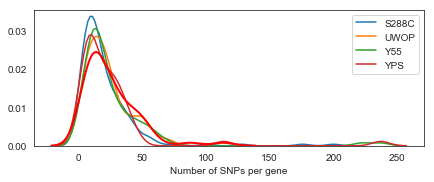

In [34]:
plt.figure(figsize=(7, 2.5))

# for i in o[o['set'].str.startswith('random')]['set'].unique():
#     sns.kdeplot(o[o['set'] == i]['chromosome'],
#                 color='grey',
#                 label='_')
for i in o[o['set'].str.startswith('strain')]['set'].unique():
    sns.kdeplot(o[o['set'] == i]['chromosome'],
                label=i.replace('strain', ''))
sns.kdeplot(o[o['set'] == 'shared']['chromosome'],
            lw=2,
            color='r',
            label='_')
plt.xlabel('Number of SNPs per gene');

/home/mgalactus/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


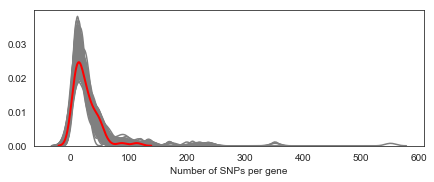

In [35]:
plt.figure(figsize=(7, 2.5))

for i in o[o['set'].str.startswith('random')]['set'].unique():
    sns.kdeplot(o[o['set'] == i]['chromosome'],
                color='grey',
                label='_')
# for i in o[o['set'].str.startswith('strain')]['set'].unique():
#     sns.kdeplot(o[o['set'] == i]['chromosome'],
#                 label=i.replace('strain', ''))
sns.kdeplot(o[o['set'] == 'shared']['chromosome'],
            lw=2,
            color='r',
            label='_')
plt.xlabel('Number of SNPs per gene');